# Text classification with Tensorflow

Getting useful information from source text can be time-consuming.
However, thanks to NLP (Natural Language Processing) and machine learning, text analysis can be made much easier!
In this case, I will train a model with the help of Tensorflow to classify whether a review is positive or negative. To train the model, I will use free-to-use 'Disneyland reviews' -dataset from Kaggle. Link: https://www.kaggle.com/arushchillar/disneyland-reviews

To do the sentiment analysis, I will have to:
    - Create directory structure including sample files from the data.
    - Train the neural network with the extracted data.
    - Validate the operation of your trained model.
Let's get started.

First, import all the necessary libraries. Read the csv file DisneylandReviews.csv into a data structure so we can handle it later.

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import csv
from tensorflow.keras import layers, losses, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
review_data = pd.read_csv('data_files\DisneylandReviews.csv', delimiter=",")
review_data.drop(["Branch", "Reviewer_Location", "Year_Month", "Review_ID"], inplace=True, axis=1)
review_data

,Rating,Review_Text
0,4,If you've ever been to Disneyland anywhere you...
1,4,Its been a while since d last time we visit HK...
2,4,Thanks God it wasn t too hot or too humid wh...
3,4,HK Disneyland is a great compact park. Unfortu...
4,4,"the location is not in the city, took around 1..."
...,...,...
42651,5,i went to disneyland paris in july 03 and thou...
42652,5,2 adults and 1 child of 11 visited Disneyland ...
42653,5,My eleven year old daughter and myself went to...
42654,4,"This hotel, part of the Disneyland Paris compl..."


Then we create the directory structure presented below. There should be *disney_review_data* directory which has two subdirectories: *train* and *test*. Both of those directories should then have two subdirectories: *pos* and *neg*.

```
disney_review_data
    |
    |----train
    |      |----pos
    |      |----neg
    |
    |----test
           |----pos
           |----neg
```

After that we loop through the saved data and save it as text files (.txt) into the directory structure. First 80 % of the data should go into *pos* and *neg* subdirectories under the *train* directory with the following conditions:
- pos = rating is 4 or more
- neg = rating is 2 or less

The last 20 % should go into the *pos* and *neg* subdirectories under the *test* directory using the same conditions as above. They will be used later during the model's testing phase.

Rating value of 3 is considered to be neutral and will not be processed.

In [4]:
# Function that writes ratings to their correct directory depending on its rating
def writeReviews(df):
    train_num = round(df.shape[0] * 0.8)
    train_data = df[:train_num]
    
    #Seperate negative and positive reviews and write them to train directory
    pos_mask = train_data[(train_data["Rating"] >= 4)]
    neg_mask = train_data[(train_data["Rating"] <= 2)]
    writeToFile("disney_review_data\\train\\pos\\", pos_mask)
    writeToFile("disney_review_data\\train\\neg\\", neg_mask)
    
    #Same as above but for test directory
    test_data = df[train_num:-1]
    testPos_mask = test_data[(test_data["Rating"] >= 4)]
    testNeg_mask = test_data[(test_data["Rating"] <= 2)]
    writeToFile("disney_review_data\\test\\pos\\", testPos_mask)
    writeToFile("disney_review_data\\test\\neg\\", testNeg_mask)

# Function to write review texts to given path
def writeToFile(path, df):
    i = 0
    for index, row in df.iterrows():
        if i > len(df):
            break
        else:
            f = open(path + str(i) + "_" +str(row["Rating"]) + '.txt', 'w')
            f.write(row["Review_Text"])
            f.close()
            i+=1

writeReviews(review_data)

Next we implement the text classification model. The model will use the previously created Disneyland review data. I will run the notebook and ensure that no errors are present.

In [5]:
#Init params that are used more than once in this code
batch_size = 32
validation_split = 0.2
seed = 42
dataset_dir = 'disney_review_data'
max_features = 10000

In [6]:
# Set train directory and check the content
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg', 'pos']

In [7]:
# Keras library has a method called text_dataset_from_directory which we will use for reading all text files from target directory.
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory('disney_review_data/train', batch_size=batch_size, validation_split=validation_split, subset="training", seed=seed)

Found 30380 files belonging to 2 classes.
Using 24304 files for training.


In [8]:
# Prepare the validation dataset with similar parameters like we did with the training dataset earlier
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory('disney_review_data/train', batch_size=batch_size, validation_split=validation_split, subset='validation', seed=seed)

Found 30380 files belonging to 2 classes.
Using 6076 files for validation.


In [9]:
# For test dataset we are utilizing the whole dataset so no splitting is involved here
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory('disney_review_data/test', batch_size=batch_size)

Found 7166 files belonging to 2 classes.


In [10]:
# Function to sanitize text from unwanted HTML tags and such
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

After standardizing our text we move to the tokinization and vectorization phase. This tokenizes the words and transform the whole text into a series of integers.

In [11]:
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

In [12]:
# Map our training text dataset to our TextVectorization layer which will return the series of integers
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [13]:
# Function that we can use for checking how our text processing works.
# also, we will use this function for processing the texts from our training, validation and test datasets.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [14]:
# Check how data is processed into vectorized format (array of integers)
text_batch, label_batch = next(iter(raw_train_ds))
test_review, test_label = text_batch[0], label_batch[0]
print("Review", test_review)
print("Label", raw_train_ds.class_names[test_label])
print("Vectorized review", vectorize_text(test_review, test_label))

Review tf.Tensor(b"I think, everyone who knows Disney characters in their childhood days should love this park. When I came here, I spent about 9 hours in several zones. One zone comprises of a lot of amusements, so I think anyone would not leave a zone in less than 1,5 hours. Merchandise shops and food courts are everywhere. Don't forget to experience Philharmagic show and the rollercoasters. Make sure you watch the firework (by the time I arrived, I failed to catch the firework due to bad weather, all day). The food: If you could stand not eating all day, it would be good, because the foods are quite expensive (if we compare the price and the delicacy). The staffs: Overall are good, but some of them may not be able to speak English at all.", shape=(), dtype=string)
Label pos
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  14,  204,  216,  176, 1523,   26,  126,    8,  130,  655,   95,
         264,  121,   34,   15,   59,   14,  379,  115,   14,  228,   8

In [15]:
# Examples from the output array are presented below
print("2 ---> ",vectorize_layer.get_vocabulary()[2])
print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("10 ---> ",vectorize_layer.get_vocabulary()[10])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2 --->  the
7 --->  we
10 --->  it
Vocabulary size: 10000


In [16]:
# Before moving into the training step, we will apply the TextVectorization layer for all our three datasets
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [17]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, 16),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


Now that the text vectorialization and layer is done, we proceed to compile our model

In [18]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

We're ready to train the model using the validation dataset (val_ds). We will do 15 epochs for the whole dataset.

In [19]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
760/760 [==============================] - 39s 52ms/step - loss: 0.3244 - binary_accuracy: 0.9202 - val_loss: 0.2548 - val_binary_accuracy: 0.9218
Epoch 2/15
760/760 [==============================] - 17s 22ms/step - loss: 0.2508 - binary_accuracy: 0.9203 - val_loss: 0.2428 - val_binary_accuracy: 0.9218.2529 - bi
Epoch 3/15
760/760 [==============================] - 16s 21ms/step - loss: 0.2354 - binary_accuracy: 0.9205 - val_loss: 0.2273 - val_binary_accuracy: 0.9226
Epoch 4/15
760/760 [==============================] - 17s 23ms/step - loss: 0.2164 - binary_accuracy: 0.9239 - val_loss: 0.2078 - val_binary_accuracy: 0.9268
Epoch 5/15
760/760 [==============================] - 18s 24ms/step - loss: 0.1945 - binary_accuracy: 0.9316 - val_loss: 0.1867 - val_binary_accuracy: 0.9329
Epoch 6/15
760/760 [==============================] - 16s 22ms/step - loss: 0.1709 - binary_accuracy: 0.9376 - val_loss: 0.1681 - val_binary_accuracy: 0.9373
Epoch 7/15
760/760 [======================

In [20]:
# Loss indicates how bad our model's prediction was and accuracy value tells how often our model gave the correct prediction compared to true data.
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

224/224 [==============================] - 29s 130ms/step - loss: 0.1699 - binary_accuracy: 0.9332
Loss:  0.16993315517902374
Accuracy:  0.9331565499305725


After training, I want to visualize the loss and accuracy of our model.

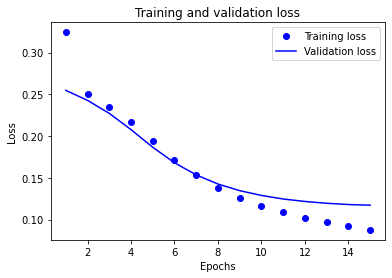

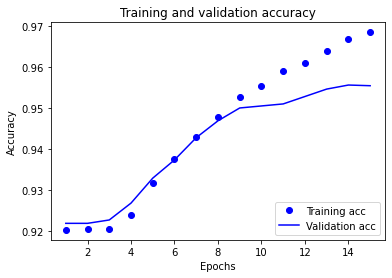

In [21]:
history_dict = history.history
history_dict.keys()

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Now we can create some test data to verify that your model works!

In [22]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

224/224 [==============================] - 3s 15ms/step - loss: 0.1699 - accuracy: 0.9332
0.9331565499305725


In [23]:
examples = [
  "The park was good. I liked it.",
  "The park was okay. However, not as good as I thought it would be.",
  "I went to the disney park yesterday. It was so crowded and smelly...",
  "The park was horrible...",
  "The park was the best park I've ever been to! Great sights! Unbelievable scenery throughout the park",
  "I did not like the park and I won't recommend it to anyone! DO NOT GO! One of the worst disney parks i've been to."
]

results = export_model.predict(examples)
results

array([[0.9618225 ],
       [0.9185215 ],
       [0.8779759 ],
       [0.87797284],
       [0.9784395 ],
       [0.7261934 ]], dtype=float32)

The model gives points to the examples based on its previous training. **Note:** The model has not seen these examples before.

The points the model gives can be normalized further so they don't gravitate so heavily towards 1.0, however even without that the model succesfully can differentiate between negative and positive reviews on most cases. The cutoff between positive and negative review is somewhere around 0.90 